In [1]:
# Load SD
%load_ext autoreload
%autoreload 2
%matplotlib inline

# %env CUDA_LAUNCH_BLOCKING=1
%env CUDA_VISIBLE_DEVICES=0


env: CUDA_VISIBLE_DEVICES=0


In [2]:
from lib_prior.diffusion.sd_sds import StableDiffusionSDS
from lib_prior.diffusion.ctrl_sd_prior import CtrSDPrior
from lib_prior.diffusion.ldm3d_sds import LDM3D_SDS
import torch
from matplotlib import pyplot as plt

# prior = CtrSDPrior()
prior = StableDiffusionSDS(device=torch.device("cuda"), t_range=[0.01, 0.05], fp16=False)

# prior = LDM3D_SDS(device=torch.device("cuda:0"), t_range=[0.01, 0.05], fp16=False)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

/tmp/ipykernel_2159297/3027231824.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  bad_img = imageio.imread(img_fn)[:360,:360]


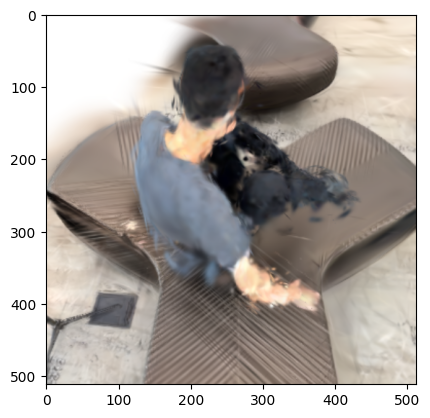

In [3]:
import os, os.path as osp
import imageio, cv2

prompt = "a young boy sitting on a big furniture"
neg_prompt = "ugly, blured, bad quality"
target_res = 512

img_fn = osp.join("./data/iphone_4x_dev/spin/log/iphone_4x.yaml20240502_181814/test/1_00000.png")
bad_img = imageio.imread(img_fn)[:360,:360]
bad_img = cv2.resize(bad_img, (target_res, target_res))
plt.imshow(bad_img)

In [21]:
t = torch.tensor(100)
latents = prior.encode_imgs(torch.from_numpy(bad_img).permute(2,0,1).unsqueeze(0).float().cuda())
noise = torch.randn_like(latents)
latents_noisy = prior.scheduler.add_noise(latents, noise, t)

print(latents.shape)

torch.Size([1, 4, 64, 64])


tensor([981, 961, 941, 921, 901, 881, 861, 841, 821, 801, 781, 761, 741, 721,
        701, 681, 661, 641, 621, 601, 581, 561, 541, 521, 501, 481, 461, 441,
        421, 401, 381, 361, 341, 321, 301, 281, 261, 241, 221, 201, 181, 161,
        141, 121, 101,  81,  61,  41,  21,   1])


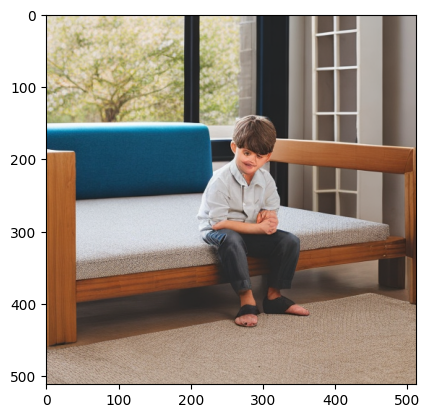

In [5]:
# prior.scheduler.set_timesteps(num_inference_steps=20, offset=t)
# print(prior.scheduler.timesteps)
img1 = prior.prompt_to_img(prompt, neg_prompt, 512, 512, 50)
plt.imshow(img1[0])


(1, 512, 512, 3)
torch.Size([1, 4, 64, 64])
(1, 512, 512, 3)


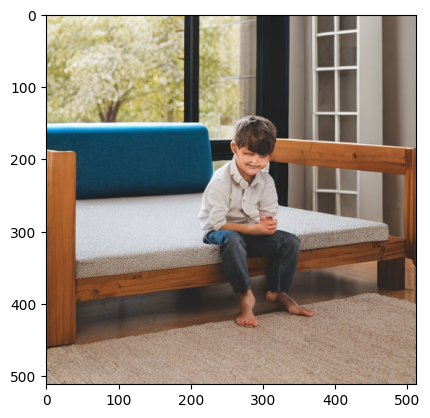

In [53]:
import numpy as np
t = torch.tensor(100)
print(img1.shape)

latents = prior.encode_imgs(torch.from_numpy(img1.astype(np.float32)/255).cuda().permute(0,3,1,2))
noise = torch.randn_like(latents)
latents_noisy = prior.scheduler.add_noise(latents, noise, t)
print(latents.shape)

imgs = prior.prompt_to_img("a young boy sitting on a big furniture, top down view", neg_prompt, 512, 512, 400, latents=latents_noisy,start_t=t, guidance_scale=10.0)
# imgs = prior.prompt_to_img(prompt, neg_prompt, 512, 512, 50, latents=latents_noisy, guidance_scale=7.5)
print(imgs.shape)
plt.imshow(imgs[0])

(1, 512, 512, 3)


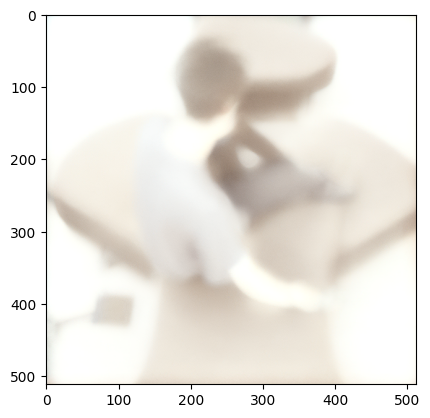

In [51]:
torch.cuda.empty_cache()

t = torch.tensor(100)
latents = prior.encode_imgs(torch.from_numpy(bad_img).permute(2,0,1).unsqueeze(0).float().cuda())
noise = torch.randn_like(latents)
latents_noisy = prior.scheduler.add_noise(latents, noise, t)

imgs = prior.prompt_to_img("a young boy sitting on a big furniture, top down view", neg_prompt, 512, 512, 400, latents=latents_noisy,start_t=t, guidance_scale=10.0)
# imgs = prior.prompt_to_img(prompt, neg_prompt, 512, 512, 50, latents=latents_noisy, guidance_scale=7.5)
print(imgs.shape)
plt.imshow(imgs[0])

In [7]:
raise RuntimeError("Stop here")

RuntimeError: Stop here

In [ ]:
prompt = "a young boy sitting on a big furniture"
neg_prompt = "ugly, blured, bad quality"

imgs = prior.prompt_to_img(prompt, neg_prompt, 512, 512, 50)
print(imgs.shape)
plt.imshow(imgs[0])

In [ ]:
plt.imshow(imgs[0,...,:3]), plt.show()
plt.imshow(imgs[0,...,3:])

In [ ]:
# Load optimzied 4D Model

import torch
import os, os.path as osp
import logging
from lib_4d.solver_gs import Solver
from lib_4d.cfg_helpers import OptimCFG, GSControlCFG

from lib_prior.diffusion.sd_sds import StableDiffusionSDS
import numpy as np
from lib_4d.camera import SimpleFovCamerasIndependent
from lib_4d.gs_static_model import StaticGaussian
from lib_4d.gs_ed_model import DynSCFGaussian
from lib_4d.scf4d_model import Scaffold4D
from lib_4d.eval_utils.eval_nvidia import eval_nvidia_dir
import imageio
from omegaconf import OmegaConf
from lib_data.iphone_helpers import load_iphone_gt_poses
from lib_data.nvidia_helpers import load_nvidia_gt_pose, get_nvidia_dummy_test

from lib_4d.solver_viz_helper import viz_curve
from lib_4d.prior2d import Prior2D

from lib_4d.solver_dynamic_funcs import solve_4dscf, grow_node_by_coverage

In [ ]:
from run import get_cfg

cfg_fn = "./configs/iphone_4x.yaml"
src = "./data/iphone_4x_dev/spin"
dyn_gs_dir = "./data/iphone_4x_dev/spin/log/iphone_4x.yaml20240502_181814" # ! this is the dense long version
device = torch.device("cuda:0")
depth_mode = "gt"
cfg = get_cfg(cfg_fn)

dataset_mode = getattr(cfg, "dataset_mode", "iphone")
max_sph_order = getattr(cfg, "max_sph_order", 1)

In [ ]:
solver = Solver(
    src,
    device,
    temporal_diff_shift=getattr(cfg, "temporal_diff_shift", [2, 8]),
    temporal_diff_weight=getattr(cfg, "temporal_diff_weight", [0.6, 0.4]),
    log_prefix="sd_debug_" + osp.basename(cfg_fn),
)
solver.prior2d = Prior2D(
    dino_name="dino_lr",  # ! looks like the LR is better for now
    log_dir=solver.log_dir,
    src_dir=src,
    working_device=device,
    depth_mode=depth_mode,
    min_valid_cnt=1,
    epi_error_th_factor=getattr(cfg, "epi_error_th_factor", 400.0),
    mask_prop_steps=getattr(cfg, "mask_prop_steps", 0),
    use_short_track=getattr(cfg, "use_short_flow", False),
    flow_interval=getattr(cfg, "flow_interval", [1]),
    semantic_th_quantile=getattr(cfg, "semantic_th_quantile", 0.95),
    depth_boundary_th=getattr(cfg, "depth_boundary_th", 0.5),
)
(
    gt_training_cam_T_wi,
    gt_testing_cam_T_wi_list,
    gt_testing_tids_list,
    gt_testing_fns_list,
    gt_training_fov,
    gt_testing_fov_list,
    gt_training_cxcy_ratio,
    gt_testing_cxcy_ratio_list,
) = load_iphone_gt_poses(src, getattr(cfg, "t_subsample", 1))

d_model_ckpt = torch.load(osp.join(dyn_gs_dir, "finetune_d_model.pth"))
d_model = DynSCFGaussian.load_from_ckpt(d_model_ckpt, device=device)
# * load static model and camera again, because it's also finetuned
saved_cam = torch.load(osp.join(dyn_gs_dir, "finetune_s_model_cam.pth"))
cams: SimpleFovCamerasIndependent = solver.get_cams(
    fovdeg=float(gt_training_fov),
    gt_pose=gt_training_cam_T_wi,
    gt_fovdeg=float(gt_training_fov),
    cxcy_ratio=gt_training_cxcy_ratio[0],  # gt camera center
)
cams.load_state_dict(saved_cam, strict=True)
s_model = StaticGaussian(
    load_fn=osp.join(dyn_gs_dir, "finetune_s_model.pth"),
    max_sph_order=max_sph_order,
).to(device)
solver.prior2d.compute_normal_maps(
    cams,
    patch_size=getattr(cfg, "normal_patch_size", 7),
    nn_dist_th=getattr(cfg, "normal_nn_dist_th", 0.03),
    nn_min_cnt=getattr(cfg, "normal_nn_min_cnt", 4),
)

In [ ]:
prior.get_text_embeds("a young boy sitting on big furnitures", "incomplete, ugly, blurred")

In [ ]:
from campose_alignment import align_ate_c2b_use_a2b

# prepare novel views
use_gt_cam = True

(
    gt_training_cam_T_wi,
    gt_testing_cam_T_wi_list,
    gt_testing_tids_list,
    gt_testing_fns_list,
    gt_training_fov,
    gt_testing_fov_list,
    gt_training_cxcy_ratio,
    gt_testing_cxcy_ratio_list,
) = load_iphone_gt_poses(src, getattr(cfg, "t_subsample", 1))


sds_T_list = []
for test_camera_T_wi in gt_testing_cam_T_wi_list:
    solved_cam_T_wi = torch.stack([cams.T_wc(i) for i in range(cams.T)], 0)
    aligned_test_camera_T_wi = align_ate_c2b_use_a2b(
        traj_a=gt_training_cam_T_wi,
        traj_b=solved_cam_T_wi.detach().cpu(),
        traj_c=test_camera_T_wi,
    )
    sds_T_list.append(aligned_test_camera_T_wi[0])


In [ ]:
solver.finetune_gs_model(
    total_steps=3000,
    optim_cam_after_steps=100000,
    skinning_corr_start_steps=0,
    cams=cams,
    s_model=s_model,
    d_model=d_model,
    # losses
    lambda_rgb=1.0,
    lambda_dep=0.05,
    dep_st_invariant=True,
    lambda_normal=0.2,
    lambda_depth_normal=0.05,
    lambda_distortion=100.0,
    lambda_acc_rot_reg=1.0,
    lambda_acc_xyz_reg=1.0,
    lambda_arap_coord=3.0,
    lambda_arap_len=3.0,
    geo_reg_start_steps=0,
    gt_cam_flag=use_gt_cam,
    optimizer_cfg=OptimCFG(
        lr_cam_f=0.0,
        lr_cam_q=0.0001 if not use_gt_cam else 0.0,
        lr_cam_t=0.0001 if not use_gt_cam else 0.0,
        # gs
        lr_p=0.00016,
        lr_q=0.001,
        lr_s=0.005,
        lr_o=0.05,
        lr_sph=0.0025,
        lr_p_final=0.00016 / 100.0,
        # node
        lr_np=0.00016,
        lr_np_final=0.00016 / 100.0,  # 10
        lr_nq=0.00016,
        lr_nq_final=0.00016 / 100.0,  # 10
        lr_nsig=0.003,  # ! should be larger
        lr_w=0.1,
        lr_w_final=0.1 / 10.0,
    ),
    viz_skip_t=1 if cams.T < 120 else max(1, cams.T // 50),
    viz_interval=-1,
    # viz_interval=getattr(cfg.dyn_gs, "viz_interval", 999),
    viz_cheap_interval=50,
    viz_move_angle_deg=getattr(cfg.dyn_gs, "viz_move_angle_deg", 30.0),
    d_gs_ctrl_cfg=GSControlCFG(
        densify_steps=300,
        reset_steps=2000,
        prune_steps=300,
        densify_max_grad=0.0002,
        node_densify_max_grad=0.0004,
        densify_percent_dense=getattr(cfg.dyn_gs.d_ctrl, "densify_percent_dense", 0.01),
        prune_opacity_th=getattr(cfg.dyn_gs.d_ctrl, "prune_opacity_th", 0.05),
        node_prune_opacity_th=getattr(cfg.dyn_gs.d_ctrl, "node_prune_opacity_th", 0.05),
        reset_opacity=getattr(cfg.dyn_gs.d_ctrl, "reset_opacity", 0.01),
    ),
    s_gs_ctrl_cfg=GSControlCFG(
        densify_steps=getattr(cfg.dyn_gs.s_ctrl, "densify_steps", 1200),
        reset_steps=getattr(cfg.dyn_gs.s_ctrl, "reset_steps", 1501),
        prune_steps=getattr(cfg.dyn_gs.s_ctrl, "prune_steps", 300),
        densify_max_grad=getattr(cfg.dyn_gs.s_ctrl, "densify_max_grad", 0.0008),
        densify_percent_dense=getattr(cfg.dyn_gs.s_ctrl, "densify_percent_dense", 0.01),
        prune_opacity_th=getattr(cfg.dyn_gs.s_ctrl, "prune_opacity_th", 0.05),
        reset_opacity=getattr(cfg.dyn_gs.s_ctrl, "reset_opacity", 0.01),
    ),
    s_gs_ctrl_start_ratio=0.01,
    d_gs_ctrl_start_ratio=0.01,  # 0.01 # debug
    # viz
    viz_ref_train_camera_T_wc=gt_training_cam_T_wi,
    viz_test_camera_T_wc_list=(
        [T[0] for T in gt_testing_cam_T_wi_list]
        if len(gt_testing_cam_T_wi_list) > 0
        else None
    ),
    random_bg=getattr(cfg.dyn_gs, "random_bg", False),
    # sds
    sd_prior = prior,
    sd_novel_view_list = sds_T_list,
    lambda_sds = 1.0,
)

In [ ]:
raise RuntimeError()

In [ ]:
%matplotlib inline

from pytorch3d.ops import knn_points
from lib_4d.campose_alignment import align_ate_c2b_use_a2b
from lib_4d.render_helper import render, RGB2SH
import matplotlib.pyplot as plt

test_i = 1
testing_fov = gt_testing_fov_list[test_i]
testing_focal = 1.0 / np.tan(np.deg2rad(testing_fov) / 2.0)

solved_cam_T_wi = torch.stack([cams.T_wc(i) for i in range(cams.T)], 0)
aligned_test_camera_T_wi = align_ate_c2b_use_a2b(
    traj_a=gt_training_cam_T_wi,
    traj_b=solved_cam_T_wi.detach().cpu(),
    traj_c=gt_testing_cam_T_wi_list[test_i],
)

ret = []
# for _tid in tqdm(range(len(test_camera_tid))):
_tid = 106
cover_factor=0.3

with torch.no_grad():
    
    d_mu, d_fr, d_s, d_o, d_sph = d_model(_tid)
    s_mu, s_fr, s_s, s_o, s_sph = s_model()
    print(d_sph[0])
    
    render_dict = render(
        [s_model(), (d_mu, d_fr, d_s, d_o, d_sph)],
        solver.prior2d.H,
        solver.prior2d.W,
        cams.rel_focal,
        cams.cxcy_ratio,
        T_cw=torch.linalg.inv(aligned_test_camera_T_wi[0]).to(device),
    )
    
    # make mask
    render_obs_dict = render(
        [(d_mu, d_fr, d_s, d_o, d_sph )],
        solver.prior2d.H,
        solver.prior2d.W,
        cams.rel_focal,
        cams.cxcy_ratio,
        T_cw=cams.T_cw(_tid),
    )
    obs_alpha = render_obs_dict["alpha"].squeeze(0).detach()
    # obs_dep = render_obs_dict["dep"].squeeze(0).detach() /torch.clamp(obs_alpha, min=1e-6)
    obs_dep = render_obs_dict["dep"].squeeze(0).detach()
    
    
    fg_mask = obs_alpha > 0.95
    
    pts_cam = cams.backproject(solver.prior2d.homo_map[fg_mask], obs_dep[fg_mask])
    pts_world = cams.trans_pts_to_world(_tid, pts_cam)
    np.savetxt("./debug/world_dep.xyz", pts_world.detach().cpu().numpy())
    
    
    # identify for all gs pts, which point is visible
    dist_sq, nn_ind, _ = knn_points(d_mu[None], pts_world[None], K=1)
    certain_gs_mask = dist_sq[0,:,0] < (d_model.scf.spatial_unit*cover_factor)**2
    print(certain_gs_mask.shape, certain_gs_mask.float().mean())
    
    # manually 
    certain_color = RGB2SH(torch.tensor([0.0,1.0,0.0])).to(device)
    certain_color = torch.cat([certain_color, torch.zeros(d_sph.shape[1]-3).to(device)])
    free_color = RGB2SH(torch.tensor([1.0,0.0,0.0])).to(device)
    free_color =torch.cat([free_color, torch.zeros(d_sph.shape[1]-3).to(device)])
    bg_color = RGB2SH(torch.tensor([0.0,0.0,1.0])).to(device)
    bg_color =torch.cat([bg_color, torch.zeros(d_sph.shape[1]-3).to(device)])
    d_sph[certain_gs_mask] = certain_color[None]
    d_sph[~certain_gs_mask] = free_color[None]
    
    s_sph[:] = bg_color[None]
    
    render_mask_dict = render(
        [(s_mu, s_fr, s_s, s_o, s_sph), (d_mu, d_fr, d_s, d_o, d_sph)],
        solver.prior2d.H,
        solver.prior2d.W,
        cams.rel_focal,
        cams.cxcy_ratio,
        T_cw=torch.linalg.inv(aligned_test_camera_T_wi[0]).to(device),
    )
    
    

rgb = render_dict["rgb"].permute(1, 2, 0).detach().cpu().numpy()    
rgb = np.clip(rgb, 0, 1)
mask_rgb = render_mask_dict["rgb"].permute(1, 2, 0).detach().cpu().numpy()
mask_rgb = np.clip(mask_rgb, 0, 1)
alpha = render_mask_dict["alpha"].squeeze(0).detach().cpu().numpy()

uncertain_mask = (mask_rgb[...,0] > 0.5) | (alpha < 0.5)

plt.imshow(render_obs_dict["rgb"].permute(1, 2, 0).detach().cpu().numpy()), plt.title("Observed"), plt.show()

plt.imshow(rgb), plt.title("Rendered RGB"), plt.show()
plt.imshow(mask_rgb), plt.title("Rendered Mask"), plt.show()
# plt.imshow(alpha), plt.title("Alpha Mask"), plt.show()
plt.imshow(uncertain_mask), plt.title("Uncertain Mask"), plt.show()

In [ ]:
# print(rgb.shape)
# print(alpha.shape)
import cv2

img_np = rgb[:360, :360]
mask = uncertain_mask[:360, :360]

target_res = 512

img_np = cv2.resize(img_np, (target_res, target_res))
mask = cv2.resize(mask.astype(np.float32), (target_res, target_res)) > 0.95

# other_mask= (np.random.rand(*mask.shape) < 0.8)
# other_mask = np.zeros_like(mask)
# other_mask[:, 180:] = True

other_mask = np.random.rand(16, 16) < 0.3
# upsample with nearest
other_mask = cv2.resize(other_mask.astype(np.float32), (target_res, target_res), interpolation=cv2.INTER_NEAREST) > 0.5
mask = mask | other_mask 

inpainted = prior.inpaint(
    img_np,
    mask,
    # "a boy is sitting and spinning",
    # "clear and beautiful",
    "a young boy sitting on a large piece of furniture",
    diff_steps=50,
)

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow((~mask)[...,None] * img_np), plt.title("mask")
plt.subplot(1,3,2)
plt.imshow(img_np), plt.title("Image")
plt.subplot(1,3,3)
plt.imshow(inpainted), plt.title("Inpainted")
plt.show()

In [ ]:
for i in range(len(gt_testing_cxcy_ratio_list)):
    frames, viz_occ_frames = solver.render_test(
        cams=cams,
        s_model=s_model,
        d_model=d_model,
        train_camera_T_wi=gt_training_cam_T_wi,
        test_camera_T_wi=gt_testing_cam_T_wi_list[i],
        test_camera_tid=gt_testing_tids_list[i],
        save_dir=osp.join(solver.log_dir, "test"),
        fn_list=gt_testing_fns_list[i],
        focal=testing_focal,
        cxcy_ratio=gt_testing_cxcy_ratio_list[i],
    )
    imageio.mimsave(osp.join(solver.log_dir, f"test_cam{i}.mp4"), frames)
    imageio.mimsave(osp.join(solver.log_dir, f"test_cam{i}_occ.mp4"), viz_occ_frames)